Leyendo archivo: /home/josefa_montoya/Josefamontoya/josefamontoya/antofagasta_dirty.csv
Frecuencia temporal dominante: H


/tmp/ipykernel_25382/3331170663.py:72: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  idx_synth = pd.date_range(
/tmp/ipykernel_25382/3331170663.py:104: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  synth_df = synth_df.interpolate(method="time", limit_direction="both")


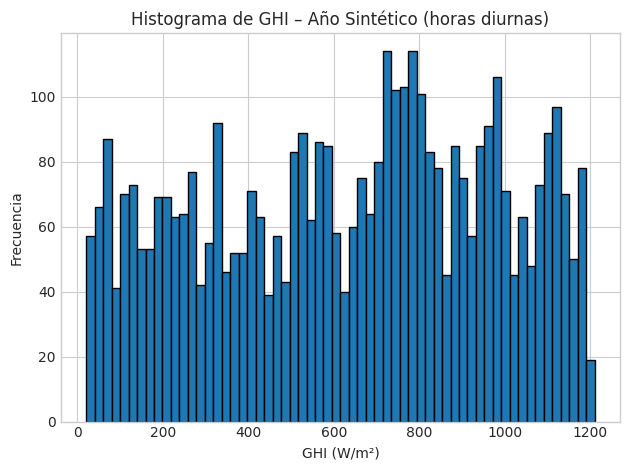

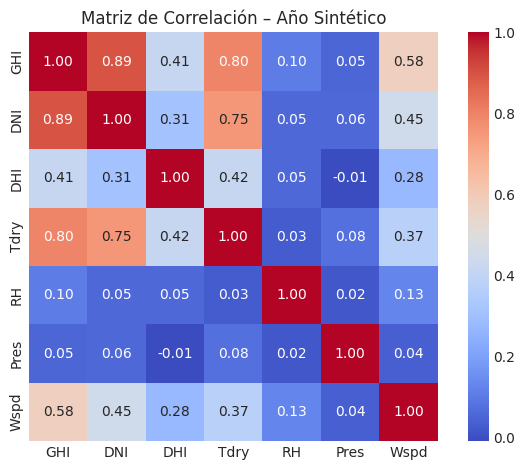

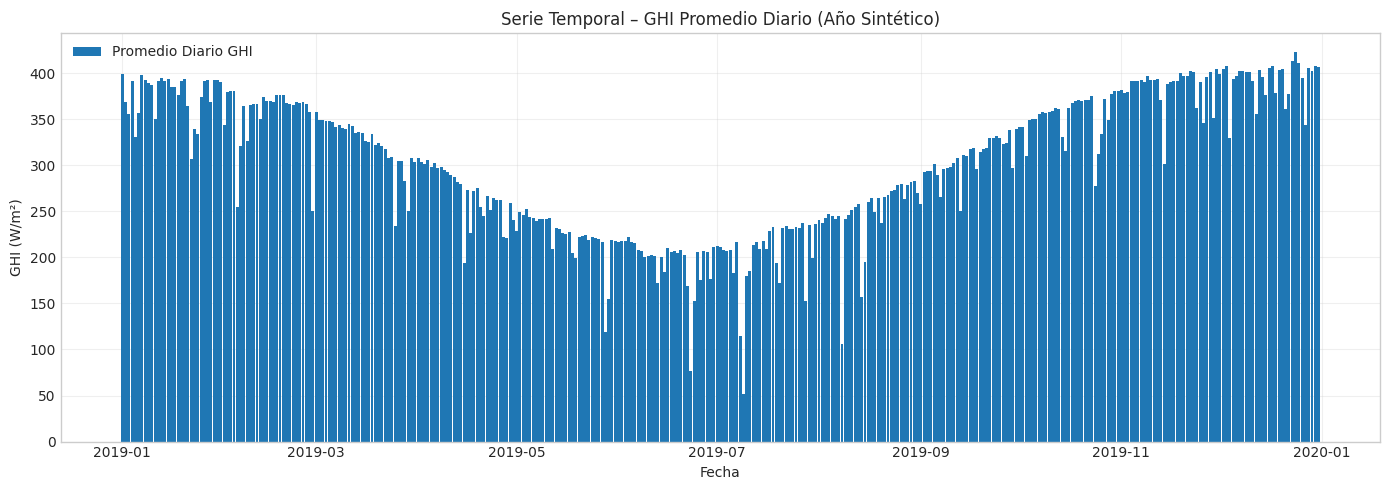

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

"""
NOTA:
Este script limpia el archivo `antofagasta_dirty.csv` y genera un **Año Sintético Continuo**
(1 de enero – 31 de diciembre, sin huecos) combinando información de varios años.

Cambios solicitados (abril 2025):
- La serie temporal diaria de GHI ahora se presenta **como gráfico de barras** en lugar de línea.
"""

# ==========================================================
# 1. Cargar archivo y preparar DataFrame
# ==========================================================
file_path = "/home/josefa_montoya/Josefamontoya/josefamontoya/antofagasta_dirty.csv"
if not os.path.exists(file_path):
    raise FileNotFoundError(f"Archivo no encontrado: {file_path}")
print(f"Leyendo archivo: {file_path}")

raw = pd.read_csv(file_path)

# Asegurarse de que existen las columnas necesarias
required_cols = ["Year", "Month", "Day", "Hour", "Minute"]
missing = [c for c in required_cols if c not in raw.columns]
if missing:
    raise ValueError(f"Faltan columnas requeridas en el CSV: {missing}")

raw["Datetime"] = pd.to_datetime(
    raw[["Year", "Month", "Day", "Hour", "Minute"]], errors="coerce"
)
raw = raw.dropna(subset=["Datetime"]).set_index("Datetime").sort_index()

# ==========================================================
# 2. Limpieza de valores físicos plausibles (Antofagasta)
# ==========================================================
limits = {
    "GHI": (0, 1300),
    "DNI": (0, 1200),
    "DHI": (0, 600),
    "Tdry": (-5, 45),
    "Tdew": (-10, 30),
    "RH": (0, 100),
    "Pres": (850, 1025),
    "Wspd": (0, 30),
    "Wdir": (0, 360),
    "Snow Depth": (0, 0),
}
for v, (vmin, vmax) in limits.items():
    if v in raw.columns:
        raw.loc[(raw[v] < vmin) | (raw[v] > vmax), v] = np.nan

# Wdir no confiable con viento casi nulo
raw.loc[(raw["Wspd"] < 0.5) & raw["Wdir"].notna(), "Wdir"] = np.nan

# ==========================================================
# 3. Inferir frecuencia temporal y crear eje de un año sintético
# ==========================================================
step_sec = raw.index.to_series().diff().dropna().dt.total_seconds().mode().iloc[0]
if step_sec < 60:
    freq = "T"  # minuto
elif step_sec < 3600:
    freq = f"{int(step_sec // 60)}T"
else:
    freq = "H"  # hora
print(f"Frecuencia temporal dominante: {freq}")

synthetic_year = 2019  # no bisiesto
idx_synth = pd.date_range(
    start=f"{synthetic_year}-01-01 00:00",
    end=f"{synthetic_year}-12-31 23:59",
    freq=freq,
)

# ==========================================================
# 4. Construir DataFrame sintético (mediana por slot)
# ==========================================================
raw_no_feb29 = raw[~((raw.index.month == 2) & (raw.index.day == 29))]
keys = [raw_no_feb29.index.month, raw_no_feb29.index.day, raw_no_feb29.index.hour]
if "T" in freq:
    keys.append(raw_no_feb29.index.minute)
median_by_slot = raw_no_feb29.groupby(keys).median(numeric_only=True)

def slot_key(ts):
    k = [ts.month, ts.day, ts.hour]
    if "T" in freq:
        k.append(ts.minute)
    return tuple(k)

synth_df = pd.DataFrame(index=idx_synth, columns=raw.columns)
for col in raw.columns:
    if col in required_cols:
        continue
    synth_df[col] = [
        median_by_slot.loc[slot_key(ts)][col]
        if slot_key(ts) in median_by_slot.index
        else np.nan
        for ts in idx_synth
    ]

synth_df = synth_df.interpolate(method="time", limit_direction="both")

# ==========================================================
# 5. Visualizaciones
# ==========================================================
plt.style.use("seaborn-v0_8-whitegrid")

# 5.1 Histograma de GHI (horas diurnas)
plt.figure()
plt.hist(
    synth_df[synth_df["GHI"] > 20]["GHI"].dropna(),
    bins=60,
    edgecolor="black",
)
plt.title("Histograma de GHI – Año Sintético (horas diurnas)")
plt.xlabel("GHI (W/m²)")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()

# 5.2 Matriz de correlación
plt.figure()
vars_corr = ["GHI", "DNI", "DHI", "Tdry", "RH", "Pres", "Wspd"]
cor = synth_df[vars_corr].corr()
sns.heatmap(cor, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Matriz de Correlación – Año Sintético")
plt.tight_layout()
plt.show()

# 5.3 Serie temporal diaria de GHI – gráfico de barras
plt.figure(figsize=(14, 5))

daily_ghi = synth_df["GHI"].resample("D").mean()
plt.bar(daily_ghi.index, daily_ghi, width=0.9, label="Promedio Diario GHI")
plt.title("Serie Temporal – GHI Promedio Diario (Año Sintético)")
plt.xlabel("Fecha")
plt.ylabel("GHI (W/m²)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ==========================================================
# 6. Guardado opcional
# ==========================================================
# out_synth = "/home/josefa_montoya/Josefamontoya/josefamontoya/antofagasta_synthetic_year.csv"
# synth_df.to_csv(out_synth)
# print(f"Año sintético guardado en: {out_synth}")